In [1]:
%load_ext autoreload
%autoreload 2

from PIL import Image
import numpy as np
from matplotlib.pylab import plt

from models.mtcnn import detect_faces, show_bboxes
from models.solov2 import nuki_faces

### 1. Target Image

In [2]:
# img = Image.open('samples/trot.png')
# Image.fromarray(np.asarray(img)[:,:,:3]).save("samples/trot.jpg")

In [3]:
# Get BBoxs
img = Image.open('samples/trot.jpg')
bboxs, landmarks = detect_faces(img)

# Convert to Nuki Boxs
nboxs = []
for bbox in bboxs:
    x0, y0, x1, y1 = bbox[:4]
    xc = (x0+x1)/2
    yc = (y0+y1)/2
    w = (x1-x0)/2 * 1.5
    h = (y1-y0)/2
    nboxs.append((
        int(max(0, xc-w)), 
        int(max(0, yc-h*2)), 
        int(min(xc+w, img.size[0])), 
        int(min(yc+h, img.size[1]))
    ))
    
masks = nuki_faces(img, nboxs)


[01/16 20:37:16 detectron2]: Arguments: {'config_file': 'models/solov2/configs/SOLOv2/R50_3x.yaml', 'input': ['samples/jsm.jpg'], 'output': 'results', 'confidence_threshold': 0.5, 'opts': ['MODEL.WEIGHTS', 'models/solov2/weights/SOLOv2_R50_3x.pth']}


/home/dajinhan/anaconda3/envs/pytorch-1.7/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "
/home/dajinhan/anaconda3/envs/pytorch-1.7/lib/python3.8/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/home/dajinhan/utils/AdelaiDet/adet/modeling/solov2/s

In [4]:
nboxs

[(298, 204, 382, 311),
 (582, 295, 654, 387),
 (421, 131, 496, 241),
 (555, 173, 627, 260)]

### 2. Source Image

In [5]:
# Get BBoxs
myimg = Image.open('samples/jsm.jpg')
mybboxs, mylandmarks = detect_faces(myimg)

# Convert to Nuki Boxs
mynboxs = []
for mybbox in mybboxs:
    x0, y0, x1, y1 = mybbox[:4]
    xc = (x0+x1)/2
    yc = (y0+y1)/2
    wr = (x1-x0)/2*1.5
    hr = (y1-y0)/2
    mynboxs.append((
        int(max(0,xc-wr)), 
        int(max(0,yc-hr*2)), 
        int(min(xc+wr, myimg.size[0])), 
        int(min(yc+hr, myimg.size[1]))))
    
mymasks = nuki_faces(myimg, mynboxs)

myx0,myy0,myx1,myy1 = mynboxs[0][:4]


[01/16 20:37:18 detectron2]: Arguments: {'config_file': 'models/solov2/configs/SOLOv2/R50_3x.yaml', 'input': ['samples/jsm.jpg'], 'output': 'results', 'confidence_threshold': 0.5, 'opts': ['MODEL.WEIGHTS', 'models/solov2/weights/SOLOv2_R50_3x.pth']}


### 3. Replace Face

In [6]:
my_img = np.asarray(myimg)
orig_img = np.asarray(img)
result_img = np.asarray(img).copy()

zip_list = zip(nboxs, masks)
zip_list = sorted(zip_list, key=lambda x : x[1].sum())
for nbox, mask in zip_list:
    # original size
    x0,y0,x1,y1 = nbox[:4]
    xc = int((x0+x1)/2)
    yc = int((y0+y1)/2)
    w = x1-x0
    h = y1-y0

    face_img = my_img[myy0:myy1, myx0:myx1, :]
    face_img = Image.fromarray(face_img)
    mask = Image.fromarray(mymasks[0].astype(np.uint8))
    
    face_img = face_img.resize((int(w*1.0), int(h*1.0)))
    mask = mask.resize((int(w*1.0), int(h*1.0)))
    
    face_img = np.asarray(face_img).copy()
    mask = np.asarray(mask)
    mask = np.expand_dims(mask, 2)
    face_img *= mask

    # new size
    nw = face_img.shape[1]
    nh = face_img.shape[0]
    for row in range(face_img.shape[0]):
        srow = row+yc+int(h/2-nh)
        if srow < 0 or srow >= result_img.shape[0]:
            continue
        for col in range(face_img.shape[1]):
            scol = col+xc-int(nw/2)
            if scol < 0 or scol >= result_img.shape[1]:
                continue
            
            if np.sum(face_img[row][col]) == 0:
                continue
                
            result_img[srow][scol] = face_img[row][col]
    
    
    

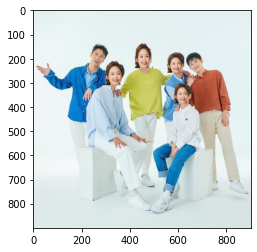

In [7]:
plt.imshow(result_img)
Image.fromarray(result_img).save("results/result_replace.jpg")